In [1]:
import os
import subprocess
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyspark import SparkContext
import operator
import warnings
import random
import math

os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'

SparkContext.setSystemProperty('spark.executor.memory', '5g')

warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# inputFile = "pre_processed_data/pre_processed_labelled_original_13.csv"
inputFile = "pre_processed_data/pre_processed_labeled.csv"
outputModel = "saved_models/Random_Forest_Model_final.pkl"

# <i>Experimenting with features

In [3]:
# all the features
features = ['sampling_id', 'loc_id', 'month', 'time', 'timeSin', 'timeCos', 'effor_hours', 'population_per_mile',\
            'housing_density', 'housing_vacant', 'OMERNIK_L3_ECOREGION', 'Average_Temp','Flowing_fresh_in',\
            'WetVeg_fresh_from', 'WetVeg_fresh_in', 'flowing_brackish_from', 'flowing_brackish_in',\
            'standing_brackish_from', 'standing_brackish_in', 'wetveg_brackish_from', 'wetveg_brackish_in',\
            'birdPresent']

# experimenting with few features
sampleFeatures = ['sampling_id', 'loc_id', 'month', 'time', 'timeSin', 'timeCos','effor_hours',\
                  'population_per_mile', 'housing_density', 'housing_vacant', 'OMERNIK_L3_ECOREGION',\
                  'Average_Temp', 'birdPresent']

# set of independent variables
independentVariables = ['loc_id', 'month', 'time', 'timeSin', 'timeCos','effor_hours',\
                        'population_per_mile', 'housing_density', 'housing_vacant', 'OMERNIK_L3_ECOREGION',\
                        'Average_Temp']

dependentVariable = 'birdPresent'

In [4]:
birdDataPD = pd.read_csv(inputFile, names = sampleFeatures)    

In [5]:
birdDataPD.head()

,sampling_id,loc_id,month,time,timeSin,timeCos,effor_hours,population_per_mile,housing_density,housing_vacant,OMERNIK_L3_ECOREGION,Average_Temp,birdPresent
0,S19205011,323822,7,0.208333,0.965926,0.258819,2.000,-999.0,-999.0,-999.0,-999,-999,0
1,S19205265,323822,7,0.208333,0.965926,0.258819,3.000,-999.0,-999.0,-999.0,-999,-999,0
2,S21300458,3285253,12,0.333333,0.866025,-0.500000,4.000,-999.0,-999.0,-999.0,-999,-999,0
3,S19745999,3071693,8,0.375000,0.707107,-0.707107,0.200,-999.0,-999.0,-999.0,-999,-999,0
4,S18238889,2829627,5,0.583333,-0.500000,-0.866025,0.333,-999.0,-999.0,-999.0,-999,-999,0


In [6]:
birdDataPD.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1701975 entries, 0 to 1701974
Data columns (total 13 columns):
sampling_id             object
loc_id                  int64
month                   int64
time                    float64
timeSin                 float64
timeCos                 float64
effor_hours             float64
population_per_mile     float64
housing_density         float64
housing_vacant          float64
OMERNIK_L3_ECOREGION    int64
Average_Temp            int64
birdPresent             int64
dtypes: float64(7), int64(5), object(1)
memory usage: 168.8+ MB


# <i>Generating Training set and Testing set

In [7]:
from sklearn.cross_validation import train_test_split

X = birdDataPD[independentVariables]
y = birdDataPD[dependentVariable]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.90, random_state=0)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1531777, 11)
(1531777,)
(170198, 11)
(170198,)


In [9]:
X_train.head()

,loc_id,month,time,timeSin,timeCos,effor_hours,population_per_mile,housing_density,housing_vacant,OMERNIK_L3_ECOREGION,Average_Temp
500295,718307,5,0.333333,0.866025,-0.500000,5.00,67.1,25.121305,0.032154,63,6
42006,2590519,1,0.416667,0.500000,-0.866025,0.50,1364.0,554.234861,0.086527,75,6
1664301,3000182,8,0.291667,0.965926,-0.258819,2.00,8.2,5.196126,0.433243,50,6
198592,129021,12,0.458333,0.258819,-0.965926,1.50,24.0,10.394246,0.078394,79,4
1496414,726694,11,0.125000,0.707107,0.707107,0.25,20.6,16.739752,0.461712,51,3


# <i>Grid Search for tunning hyperparameters

In [10]:
from sklearn.grid_search import GridSearchCV

# perform exhaustive search over specified parameter values for an estimator.
# perform cross-validation
# returns best estimator of best fitting model
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
def grid_search_best_model(estimator, params, X, y, n_jobs = -1, n_folds = 5, score_func = None, verbose = 0):
    if score_func:
        model = GridSearchCV(estimator, param_grid = params, cv = n_folds, n_jobs = n_jobs, scoring = score_func, verbose = verbose)
    else:
        model = GridSearchCV(estimator, param_grid = params, n_jobs = n_jobs, cv = n_folds, verbose = verbose)
    model.fit(X, y)
    best_model = model.best_estimator_
    return best_model

# verbose : Controls the verbosity: the higher, the more messages.
# cv : Determines the cross-validation splitting strategy.
# n_jobs : Number of jobs to run in parallel.
# param_grid : Dictionary with parameters names (string) as keys and lists of parameter settings to try as values

/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# <i>Random Forest Classification

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Regression estimator
# The number of jobs to run in parallel for both fit and predict.
# If -1, then the number of jobs is set to the number of cores.
# Training 100 trees in Forest
RF_Regressor = RandomForestClassifier(n_estimators = 100, n_jobs=-1)

<i><h4>Grid Search takes a long time to find the best model</h4>
<h4>Make sure you comment out few parametrs in RF_parameters</h4><i>

In [12]:
# Define a grid of parameters over which to optimize the random forest
# We will figure out which number of trees is optimal
RF_parameters = {"min_samples_split": [2], #[3, 4, 5]
                  "n_estimators": [100], #[80, 90, 120, 150, 200] # no. of trees in forest
                  "max_features": ["auto"], #["sqrt", "log2", "None"] # If “auto”, then max_features = n_features.
                  "max_depth": [15] #[16, 17, 18, 19, 25]
                 }
RF_best = grid_search_best_model(RF_Regressor, RF_parameters, X_train, y_train, n_folds=5, score_func='mean_squared_error', verbose=3)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100 
[CV] max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100 
[CV] max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100 
[CV] max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100 
[CV] max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100 


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100, score=-0.201985 -11.0min


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)


[CV]  max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100, score=-0.201567 -11.1min
[CV]  max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100, score=-0.200555 -11.1min


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/scorer.py:90: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 11.1min remaining: 16.6min


[CV]  max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100, score=-0.201366 -11.1min
[CV]  max_features=auto, max_depth=15, min_samples_split=2, n_estimators=100, score=-0.201335 -11.1min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.2min finished


In [13]:
RF_reg = RF_best.fit(X_train, y_train)

<h3><i>Find Training and testing accuracy</h3>

In [14]:
RF_training_accuracy = RF_reg.score(X_train, y_train)
RF_test_accuracy = RF_reg.score(X_test, y_test)
print("Accuracy on training data: ", RF_training_accuracy)
print("Accuracy on test data: ", RF_test_accuracy)
# increase in depth increases the training accuracy but decreases the test accuracy 
# i.e data sticks too much to the data

Accuracy on training data:  0.80762473911
Accuracy on test data:  0.79875204174


In [15]:
RF_y_predict = RF_reg.predict(X_test)

In [16]:
RF_reg.predict_proba(X_test)[0:10]

array([[ 0.5041329 ,  0.4958671 ],
       [ 0.69764806,  0.30235194],
       [ 0.90858874,  0.09141126],
       [ 0.22685489,  0.77314511],
       [ 0.70041968,  0.29958032],
       [ 0.82331753,  0.17668247],
       [ 0.36673672,  0.63326328],
       [ 0.6362294 ,  0.3637706 ],
       [ 0.71774759,  0.28225241],
       [ 0.96057748,  0.03942252]])

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
accuracy_score(y_test ,RF_y_predict)

0.79875204173962089

# <i>Writing model to disk

In [19]:
from sklearn.externals import joblib
joblib.dump(RF_reg, outputModel)

['saved_models/Random_Forest_Model_final.pkl']

<h3><i>Which are the most important features?</h3>

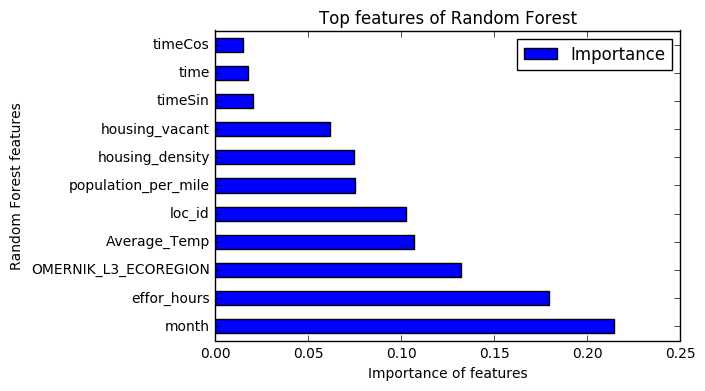

In [20]:
feature_importance_dict = dict(zip(list(independentVariables), RF_reg.feature_importances_))
# sorting features in descending order of importance
features_sorted_by_importance = sorted(feature_importance_dict.items(), key = operator.itemgetter(1), reverse = True)

# considering only top 7 features
featuresPD = pd.DataFrame(features_sorted_by_importance, columns=['Feature', 'Importance']).set_index('Feature')
featuresPD.plot(kind='barh')
plt.ylabel("Random Forest features")
plt.xlabel("Importance of features")
plt.title("Top features of Random Forest")

# <i>Actual vs Predicted Sigthings

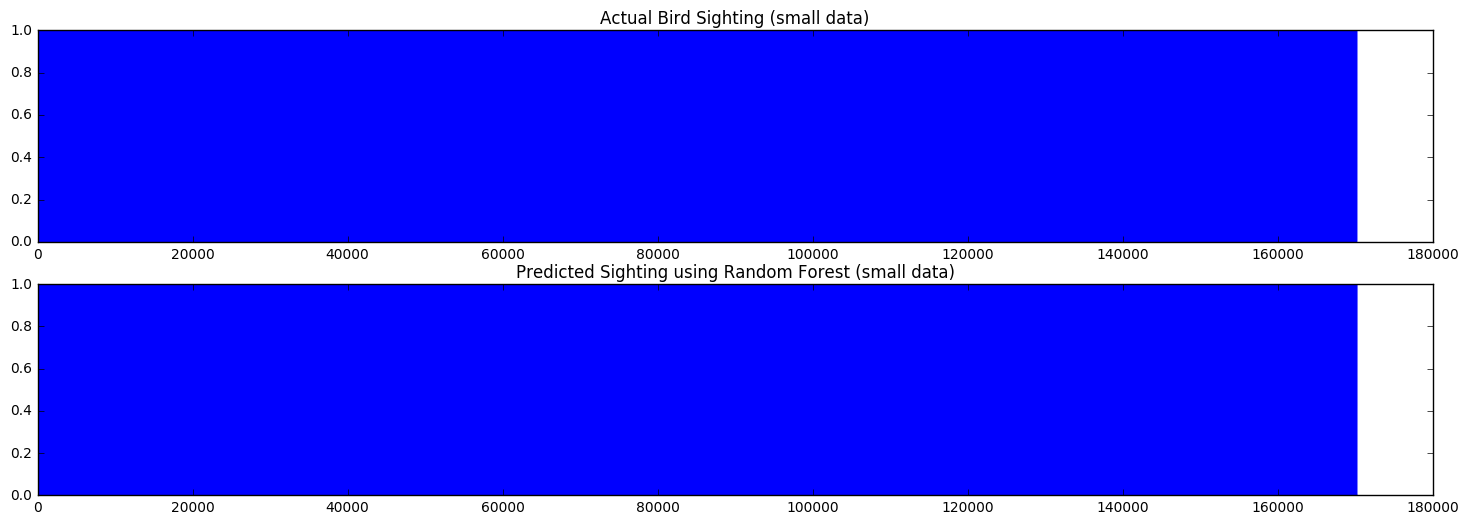

In [21]:
plt.figure(1)
plt.figure(1).set_size_inches(18, 6)

plt.subplot(211)
plt.plot(y_test.reset_index()['birdPresent'])
plt.title("Actual Bird Sighting (small data)")

plt.subplot(212)
plt.plot(RF_y_predict)
plt.title("Predicted Sighting using Random Forest (small data)")

# Decision Tree Classification

<h3><i>It is not used in final prediction. It is just used to draw the decison tree. It would give an idea about the structure (attributes) of trees in Random Forest.</h3>

In [22]:
from sklearn import datasets,tree
from io import StringIO
import pydotplus 
from sklearn.tree import export_graphviz

In [23]:
d_tree = tree.DecisionTreeClassifier()
d_tree = d_tree.fit(X_train, y_train)

In [24]:
dot_data = StringIO()
dot_data = export_graphviz(d_tree, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("Decision_tree_graph.pdf")